# Structure Optimization

In [1]:
%matplotlib notebook
import numpy as np
import torch
import matplotlib.pyplot as plt

import matplotlib
import matplotlib.cm as cm

from matplotlib import animation

In [2]:
from potentials import *
from distances import *
from sampling import *

In [3]:
delta = 0.025
x = np.arange(-1.0, 1.0, delta)
y = np.arange(-1.0, 1.0, delta)
X, Y = np.meshgrid(x, y)
XY = np.append(X[:, :, None], Y[:, :, None], axis=-1)
Z = potentials.harmonic(XY, [0, 1])

#fig, ax = plt.subplots()
#ax.contour(X, Y, Z)

#ax.clabel(CS, inline=1, fontsize=10)
#ax.set_title('Simplest default with labels')

In [4]:
def dist_torch(x): 
    """Calculates distance vectors and distances (euclidian norm of vecs)
    
    Arguments:
        x (float): position vectors (dim = N x 3)
    
    Output:
        dist (float): distances between particle pairs (dim = N x N)
        vecs (float): distance vectors between particle pairs (dim = N x N x 3)
    """
    x = torch.Tensor(x)
    vecs = x[None, :, :] - x[:, None, :]       
    return torch.norm(vecs, dim=-1), vecs

def gradLJ_t(x, sig=1, eps=1):
    dist, vecs = dist_torch(x)
    dist[dist!=0] = 1/dist[dist!=0]
    D_att = 6 * sig**6 * dist**8
    D_rep = -12 * sig**12 * dist**14
    D = 4*(eps*(D_att + D_rep))[:, :, None]*vecs
    return torch.sum(D, dim=-2)

# Felix
def vectors(coord, boxsize, pbc=False):
    vecs = coord[:, None, :] - coord[None, :, :]
    if not pbc:
        return vecs
    elif pbc:
        L = boxsize[1] - boxsize[0] #calculate boxlength
        vecs += (vecs<-0.5*L)*L - (vecs>0.5*L)*L
        return vecs

def distances(vectors):
    return np.linalg.norm(vectors,axis=-1)
    
def gradLJ(vecs, sig=1, eps=1):
    dist = distances(vecs)
    dist[dist!=0] = 1/dist[dist!=0]
    D_att = 6 * sig**6 * dist**8
    D_rep = -12 * sig**12 * dist**14
    D = 4*(eps*(D_att + D_rep))[:, :, None]*vecs
    return np.sum(D, axis=-2)

In [5]:
import random

def Random_particles( N, dim=3 ):
    """Creates a list of N particles with random positions and charges
    
    Arguments:
        N (int): number of particles
        
    Output:
        x (float): position vectors (dim = N x 3)
        q (int): charges (dim = N)
    """
    return np.random.uniform(-1,1, size=(N,dim)), np.array([[-1, 1][random.randrange(2)] for i in range(N)])

In [6]:
x_init = Random_particles(100)[0]

In [7]:
import timeit

%timeit gradLJ_t(x_init).numpy()
%timeit gradLJ(vectors(x_init, boxsize=(0,1)))

3.29 ms ± 27.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.17 ms ± 10.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [9]:
def grad_ljcho(x, q, boxsize=(0, 1)):
    vecs = vectors(x, boxsize)
    return gradients.harmonic(x, boxsize) + gradients.LJ(vecs) - gradients.coulomb(vecs, q)

def descent( x, q, grad, a=1e-4, prec=1e-10, maxst=1e6, k=.1, boxsize=(0, 1) ):
    """Gradient Descent
    
    Arguments:
        x    (float): position vectors (dim = n x 3)
        q: charge
        a    (float): 'learning rate' alpha = 1e-4
        prec (float): difference between steps, precision = 1e-10
        maxst  (int): max # of steps, maxst = 1e6
        k: factor harmonic pot
    
    Output:
        x: position array,
        step: # of steps needed to converge"""
    
    x = x[None, :, :]
    step = 0
    vecs = vectors(x[-1], boxsize)
    #f = gradients.harmonic(x[-1], boxsize) + gradients.LJ(vecs) - gradients.coulomb(vecs, q)
    f = grad(x[-1], q)
    x1 = x[-1] - a * f
    
    while step < maxst and np.linalg.norm(x[-1] - x1) > prec:
        x = np.append(x, x1[None, :, :], axis=0)
        vecs = vectors(x[-1], boxsize)
        #f = gradients.harmonic(x[-1], boxsize) + gradients.LJ(vecs) - gradients.coulomb(vecs, q)
        f = grad(x[-1], q)
        x1 = x[-1] - a * f
        step += 1
        
    return x, step

In [10]:
N = 4
dim = 2
x, y = np.linspace(-N, N, N), np.linspace(-N, N, N)
XX, YY = np.meshgrid(x,y)
q = 10.*np.array([[-1,1][random.randrange(2)] for i in range(N*N)])
print(q)
x_init =np.array([XX.flatten(),YY.flatten()]).T+np.random.uniform(low=-0.5, high=0.5,size=(N*N,dim))
#x_init *= 10
print(len(x_init))
positions, nsteps = descent(x_init, q, grad_ljcho, k=0., 
                            a=1e-4, prec=1e-5, maxst=20000)
print('# of steps:', nsteps, '| positions.shape:', positions.shape)
print('len_(x_init)', len(x_init))

[ 10. -10. -10.  10. -10. -10. -10. -10.  10. -10. -10.  10.  10.  10.
  10. -10.]
16
# of steps: 14610 | positions.shape: (14611, 16, 2)
len_(x_init) 16


In [11]:
def video( x_init, q, positions ):
    mask = np.count_nonzero(np.linalg.norm(positions[-1], axis=-1) < 10)
    print(mask)
    fig, ax = plt.subplots(figsize=(8, 8))
    colors = np.arange(len(x_init))
    scat = ax.scatter(x_init[:,0], x_init[:,1], c=q)
    circles = [plt.Circle(r, radius=0.5, fill=False) 
                for i,r in enumerate(x_init)]

    for c in circles:
        plt.gca().add_patch(c)
    ax.set_xlim(-10, 10)
    ax.set_ylim(-10, 10)
    def animate(i):
        index = 4*i
        data = positions[index]
        scat.set_offsets(data)
        for i, c in enumerate(circles):
            c.center = data[i]
        return scat

    anim = animation.FuncAnimation(fig, animate, interval=1)

16


<IPython.core.display.Javascript object>


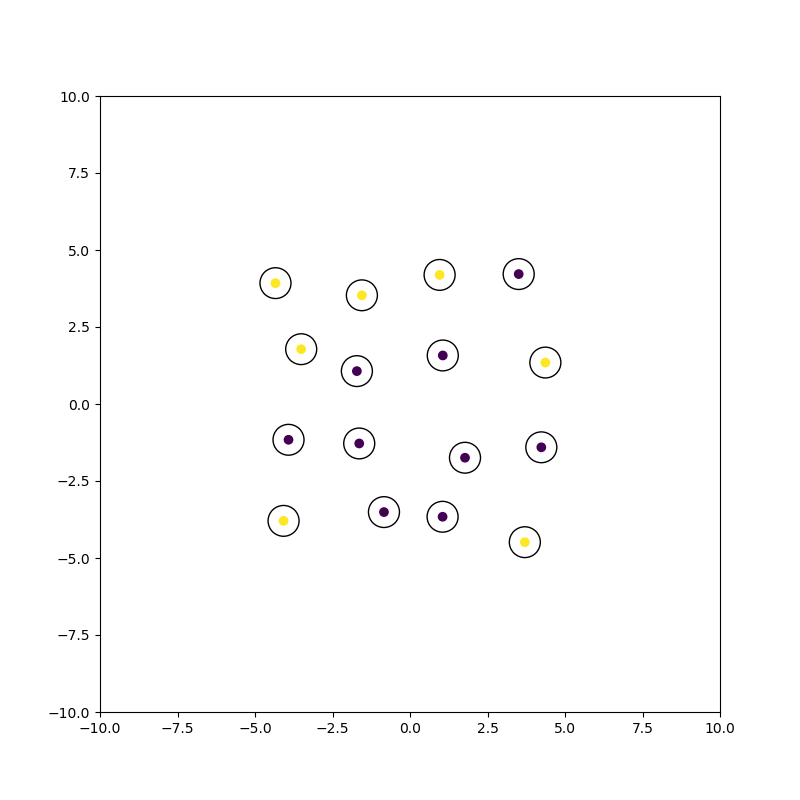

In [12]:
video(x_init, q, positions)